In [ ]:
# Install transformers library.
!pip install -q git+https://github.com/huggingface/transformers.git
# Install helper functions.
!pip install -q git+https://github.com/gmihaila/ml_things.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 1.8 MB/s eta 0:00:00


In [ ]:
import io
import os
import torch
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from ml_things import plot_dict, plot_confusion_matrix, fix_text
from sklearn.metrics import classification_report, accuracy_score
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          GPT2Config,
                          GPT2Tokenizer,
                          AdamW,
                          get_linear_schedule_with_warmup,
                          GPT2ForSequenceClassification)

# Set seed for reproducibility.
set_seed(123)

# Number of training epochs (authors on fine-tuning Bert recommend between 2 and 4).
epochs = 4

# Number of batches - depending on the max sequence length and GPU memory.
# For 512 sequence length batch of 10 works without cuda memory issues.
# For small sequence length can try batch of 32 or higher.
batch_size = 32

# Pad or truncate text sequences to a specific length
# if `None` it will use maximum sequence of word piece tokens allowed by model.
max_length = 60

# Look for gpu to use. Will use `cpu` by default if no gpu found.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Name of transformers model - will use already pretrained model.
# Path of transformer model - will load your own model from local disk.
model_name_or_path = 'gpt2'

# Dictionary of labels and their id - this will be used to convert.
# String labels to number ids.
labels_ids = {'neg': 0, 'pos': 1}

# How many labels are we using in training.
# This is used to decide size of classification head.
n_labels = len(labels_ids)

In [ ]:
!pip install datasets
from datasets import load_dataset
import re
import pandas as pd

# Load the dataset
dataset = load_dataset('ShreyaR/DepressionDetection')
dataset=dataset['train']
df=dataset.to_pandas()
df.head()

In [ ]:
from sklearn.model_selection import train_test_split
X_train = list()
X_test = list()
for label in [0,1]:
    train, test  = train_test_split(df[df.is_depression==label],
                                    train_size=750,
                                    test_size=250,
                                    random_state=42)
    X_train.append(train)
    X_test.append(test)

X_train = pd.concat(X_train).sample(frac=1, random_state=10)
X_test = pd.concat(X_test)
X_train

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,clean_text,is_depression
4743,off to london for the day on thursday it s gon...,0
5388,i cant sleep ugghhh,0
416,original text in german translated with google...,1
1539,it s march st i m so worried i wont get a job ...,1
3001,the light that shine through oh what pretty co...,1
...,...,...
2855,ezuiequotes it s a constant positive mental at...,1
3329,seasonal depression suck,1
6527,going out with josh of course i broke up with ...,0
2682,i feel at peace but i can t stop cry i m done ...,1


In [ ]:
import torch
from torch.utils.data import Dataset
from tqdm import tqdm
from transformers import GPT2Tokenizer

class DepressionDataset(Dataset):
    def __init__(self, dataframe, use_tokenizer):
        self.data = dataframe
        self.texts = self.data['clean_text'].tolist()
        self.labels = self.data['is_depression'].tolist()
        self.n_examples = len(self.labels)

    def __len__(self):
        return self.n_examples

    def __getitem__(self, item):
        return {'text': self.texts[item], 'label': self.labels[item]}

class Gpt2ClassificationCollator(object):
    def __init__(self, use_tokenizer, max_sequence_len=None):
        self.use_tokenizer = use_tokenizer
        self.max_sequence_len = use_tokenizer.model_max_length if max_sequence_len is None else max_sequence_len

    def __call__(self, sequences):
        texts = [sequence['text'] for sequence in sequences]
        labels = [sequence['label'] for sequence in sequences]
        inputs = self.use_tokenizer(text=texts, return_tensors="pt", padding=True, truncation=True, max_length=self.max_sequence_len)
        inputs.update({'labels': torch.tensor(labels)})
        return inputs

def train(dataloader, optimizer_, scheduler_, device_):
    global model
    predictions_labels = []
    true_labels = []
    total_loss = 0
    model.train()
    for batch in tqdm(dataloader, total=len(dataloader)):
        true_labels += batch['labels'].numpy().flatten().tolist()
        batch = {k: v.type(torch.long).to(device_) for k, v in batch.items()}
        model.zero_grad()
        outputs = model(**batch)
        loss, logits = outputs[:2]
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer_.step()
        scheduler_.step()
        logits = logits.detach().cpu().numpy()
        predictions_labels += logits.argmax(axis=-1).flatten().tolist()
    avg_epoch_loss = total_loss / len(dataloader)
    return true_labels, predictions_labels, avg_epoch_loss

def validation(dataloader, device_):
    global model
    predictions_labels = []
    true_labels = []
    total_loss = 0
    model.eval()
    for batch in tqdm(dataloader, total=len(dataloader)):
        true_labels += batch['labels'].numpy().flatten().tolist()
        batch = {k: v.type(torch.long).to(device_) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
            loss, logits = outputs[:2]
            logits = logits.detach().cpu().numpy()
            total_loss += loss.item()
            predictions_labels += logits.argmax(axis=-1).flatten().tolist()
    avg_epoch_loss = total_loss / len(dataloader)
    return true_labels, predictions_labels, avg_epoch_loss


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Get model configuration.
print('Loading configuraiton...')
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=n_labels)

# Get model's tokenizer.
print('Loading tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)
# default to left padding
tokenizer.padding_side = "left"
# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token


# Get the actual model.
print('Loading model...')
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)

# resize model embedding to match new tokenizer
model.resize_token_embeddings(len(tokenizer))

# fix model padding token id
model.config.pad_token_id = model.config.eos_token_id

# Load model to defined device.
model.to(device)
print('Model loaded to `%s`'%device)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Loading configuraiton...


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Loading tokenizer...


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loading model...


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded to `cpu`


In [ ]:
# Create data collator to encode text and labels into numbers.
gpt2_classificaiton_collator = Gpt2ClassificationCollator(use_tokenizer=tokenizer,
                                                          max_sequence_len=max_length)


print('Dealing with Train...')
# Create pytorch dataset.
train_dataset = DepressionDataset(X_train,
                               use_tokenizer=tokenizer)
print('Created `train_dataset` with %d examples!'%len(train_dataset))

# Move pytorch dataset into dataloader.
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=gpt2_classificaiton_collator)
print('Created `train_dataloader` with %d batches!'%len(train_dataloader))

print()

print('Dealing with Validation...')
# Create pytorch dataset.
valid_dataset =  DepressionDataset(X_test,
                               use_tokenizer=tokenizer)
print('Created `valid_dataset` with %d examples!'%len(valid_dataset))

# Move pytorch dataset into dataloader.
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
print('Created `eval_dataloader` with %d batches!'%len(valid_dataloader))

Dealing with Train...
Created `train_dataset` with 1500 examples!
Created `train_dataloader` with 47 batches!

Dealing with Validation...
Created `valid_dataset` with 500 examples!
Created `eval_dataloader` with 16 batches!


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # default is 1e-8.
                  )

# Total number of training steps is number of batches * number of epochs.
# `train_dataloader` contains batched data so `len(train_dataloader)` gives
# us the number of batches.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# Store the average loss after each epoch so we can plot them.
all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}

# Loop through each epoch.
print('Epoch')
for epoch in tqdm(range(epochs)):
  print()
  print('Training on batches...')
  # Perform one full pass over the training set.
  train_labels, train_predict, train_loss = train(train_dataloader, optimizer, scheduler, device)
  train_acc = accuracy_score(train_labels, train_predict)

  # Get prediction form model on validation data.
  print('Validation on batches...')
  valid_labels, valid_predict, val_loss = validation(valid_dataloader, device)
  val_acc = accuracy_score(valid_labels, valid_predict)

  # Print loss and accuracy values to see how training evolves.
  print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f"%(train_loss, val_loss, train_acc, val_acc))
  print()

  # Store the loss value for plotting the learning curve.
  all_loss['train_loss'].append(train_loss)
  all_loss['val_loss'].append(val_loss)
  all_acc['train_acc'].append(train_acc)
  all_acc['val_acc'].append(val_acc)

# Plot loss curves.
plot_dict(all_loss, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

# Plot accuracy curves.
plot_dict(all_acc, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Epoch


  0%|          | 0/4 [00:00<?, ?it/s]


Training on batches...



  0%|          | 0/4 [01:12<?, ?it/s]


KeyboardInterrupt: 


              precision    recall  f1-score   support

         neg       0.84      0.83      0.83     12500
         pos       0.83      0.84      0.83     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000

Normalized confusion matrix


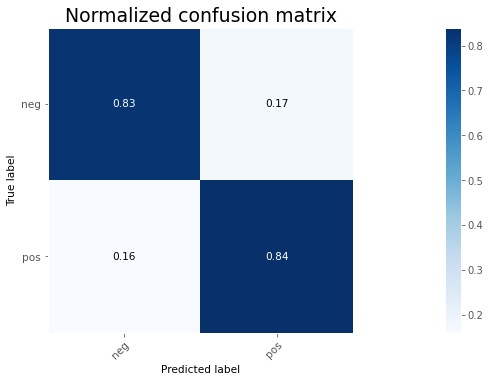

In [ ]:
# Get prediction form model on validation data. This is where you should use
# your test data.
true_labels, predictions_labels, avg_epoch_loss = validation(valid_dataloader, device)

# Create the evaluation report.
evaluation_report = classification_report(true_labels, predictions_labels, labels=list(labels_ids.values()), target_names=list(labels_ids.keys()))
# Show the evaluation report.
print(evaluation_report)

# Plot confusion matrix.
plot_confusion_matrix(y_true=true_labels, y_pred=predictions_labels,
                      classes=list(labels_ids.keys()), normalize=True,
                      magnify=0.1,
                      );